# Credit Card Default Analysis
This notebook will be dedicated to analyzing credit card records from payments in Taiwan. The goal will be to create a model that will give the predictive accuracy of the probability of defaulting on a payment. 

This dataset is aimed at the case of customer default payments in Taiwan and compares the predictive accuracy of probability of default among ~~six~~ data mining methods. I start by applying simple classification algorithms to the problem and assessing their accuracy using various measures, including accuracy, precision, recall, ROC curve, and Cohen's Kappa. This will conclude the first portion of this project, as this will tell how accurate traditional methods of classification are when trying to predict credit card defaults.

From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients. With the real probability of default as the response variable (Y), and the predictive probability of default as the independent variable (X), the simple linear regression result (Y = A + BX) shows that the forecasting model produced by artificial neural network has the highest coefficient of determination; its regression intercept (A) is close to zero, and regression coefficient (B) to one. Therefore, among the six data mining techniques, artificial neural network is the only one that can accurately estimate the real probability of default.

In [21]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from pandas.io.json import json_normalize
import seaborn
from sklearn.metrics import roc_curve, auc, average_precision_score, precision_recall_curve

In [2]:
defaults_df = pd.DataFrame.from_csv('default_of_credit_card_clients.csv')
defaults_df.shape

(30001, 24)

What is the distribution of payment among various age groups? This is a great way to 'bin' together groups and then do statistical analysis about a difference between groups, and the size.

### Attribute Information:

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables: 
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- X2: Gender (1 = male; 2 = female). 
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- X4: Marital status (1 = married; 2 = single; 3 = others). 
- X5: Age (year). 
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
- X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. 
- X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005. 

In [3]:
# Getting rid of first line mistake
new_header = defaults_df.iloc[0]
defaults_df = defaults_df[1:]
defaults_df.rename(columns = new_header)

#Renaming columns
new_header = list(new_header)
new_header[-1] = 'Y'
defaults_df.columns = new_header

print(defaults_df.shape)
defaults_df.head()

(30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
defaults_df.groupby(['Y']).size()

Y
0    23364
1     6636
dtype: int64

In [5]:
23364/6636

3.5207956600361663

In [6]:
6636/(23364+6636)

0.2212

After running some code to determine how much of the imported dataset was null or not, I found out that none of the columns had missing values. That doesn't mean there are no null values, it just means there are no values that I need to concern myself with, with regards to coverting from NULL or NaN to some logical value (average, median, regressed, etc.). 

## One-hot encoding
One-hot encoding is useful in python to train any type of model that contains categorical features. In this case, there are 9 different features that contain categorical values. Within those columns, there are varying options for distinction, such as sex having 2 options and history of past payment having 10 different values. One-hot encoding will split each of these columns into columns that have one category in the column, and whether or not that value is present in the row. Going back to the 'sex' category, this will split it into two columns called: "SEX_male" and "SEX_female", each of which will only contain binary variables. 

To do this, I will use pandas to  mutate the dataframe into something that is ready to use for ML algorithms.

In [7]:
clf_df = pd.get_dummies(defaults_df, columns=["SEX", "EDUCATION", "MARRIAGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"],
               prefix=["SEX", "EDU", "MARRY", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"])
clf_df.shape

(30000, 92)

The new df, 'clf_df', will be used for training classification models.

## Data Analysis: Training Logistic Regression Classification Models
(1.3) We would begin with Logistic Regression with regularization,
trying both L1 and L2 regularization, and getting the classical
performance metrics: accuracy, precision, recall, and ROC Curve.
If possible, also precision-recall curves and areas under
these curves. The ISLR book will be a good conceptual support
for this, and of course scikit-learn.

In [8]:
clf_df = clf_df.apply(pd.to_numeric, errors='coerce')

## Basic Model

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into a training and test set.
Xtrain, Xtest, ytrain, ytest = train_test_split(clf_df.drop('Y', axis=1),
                                                clf_df.Y, test_size=0.25, random_state=5)
clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(Xtrain, ytrain)
# Print the accuracy from the testing data. Table values.
print(accuracy_score(clf.predict(Xtest), ytest))

0.7788


## Assessing Basic Model Accuracy - Simple Accuracy
Only assessing the model by using accuracy as a measurement. I will start by using cross-validation accuracy scores, then move on to building a ROC curve, then a precision/recall curve (can be summarized by a F1 curve).
- Basic accuracy
- ROC curve
- Precision/recall curve

Questions to consider when choosing between a ROC and precision/recall curve: "How meaningful is a positive result from my classifier given the baseline probabilities of my problem?", use a PR curve. If your question is, "How well can this classifier be expected to perform in general, at a variety of different baseline probabilities?", go with a ROC curve.

In [10]:
from sklearn.model_selection import cross_val_score
clf = LogisticRegression()
scores = cross_val_score(clf, Xtrain, ytrain, cv=5)
scores

array([ 0.77849367,  0.77871584,  0.77888889,  0.7783952 ,  0.77883974])

In [11]:
from sklearn import metrics
# Trying out the f1_macro score on this dataset. Will improve after implemented regression.
scores = cross_val_score(clf, Xtrain, ytrain, cv=5, scoring='f1_macro')
scores

/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([ 0.43772642,  0.43779665,  0.43785134,  0.43868071,  0.43783581])

In [12]:
clf.fit(Xtrain, ytrain).predict(Xtest)

array([0, 0, 0, ..., 0, 0, 0])

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(ytest, clf.fit(Xtrain, ytrain).predict(Xtest)))
tn, fp, fn, tp = confusion_matrix(ytest, clf.fit(Xtrain, ytrain).predict(Xtest)).ravel()
print(tn, fp, fn, tp)
target_names = ['0', '1']
print(classification_report(ytest, clf.fit(Xtrain, ytrain).predict(Xtest), target_names=target_names))

[[5841    0]
 [1659    0]]
5841 0 1659 0
             precision    recall  f1-score   support

          0       0.78      1.00      0.88      5841
          1       0.00      0.00      0.00      1659

avg / total       0.61      0.78      0.68      7500



/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix, without normalization
[[5841    0]
 [1659    0]]


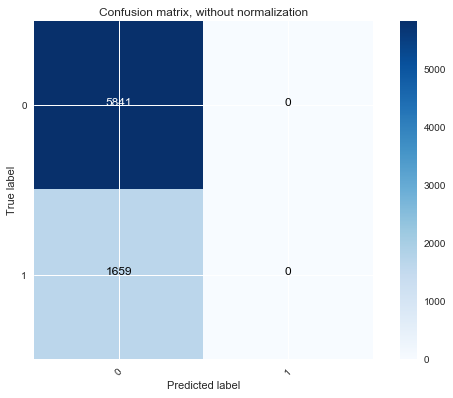

In [14]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(ytest, clf.fit(Xtrain, ytrain).predict(Xtest))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')

plt.show()

In [15]:
# Confusion Matrix and how to relate it to ROC and Precision-Recall

## Summary of Basic Logistic Regression
This model is ok. The accuracy hovers around 0.77, which is ok, but not necessarily ideal in the case of credit card defaults, where the each default could potentially be a large amount of money lost. Both the ROC curve and precision-recall curves return very average results. For the ROC curve, the area under the curve can be seen as a measure of quality of the classification model. A random classifer has an area of 0.5, as good as flipping a coin, and usually classifiers are built up from there, with a perfect classifier being equal to 1. In this case, an area of 0.66 means that a randomly selected case from the group, where the target equals 1, has a score larger than that for a randomly chosen case from the group with the target equals 0 in 66% of the time.

The Precision-Recall curve uses Recall, which is 1-specificity, or tp/(tp + fn), and precision, which is the rate of tp/(tp + fp). Recall can be thought of as indicating: how many relevant items are selected? Precision: How many selected items are relevant? For this curve, we want it to be as far and towards the top-right corner as possible, and for the AUC to be close to 1. Again, a simple measurement for the precision-recall curve is the AUC. In this case the AUC is equal to 0.35. While this doesn't mean it's worse than random, like the ROC curve, it does mean there is a lot of room for improvement.

## Tune Hyperparameters
Will use GridsearchCV from sklearn to find the optimal values of 'C' hyperparameter for regularized logistic regression. I'll start with L1 regularization and then move on to L2 to compare the two. My expectation is that L2 regression will work better than L1 regularization, as L1 typically works better for data that is sparse, which is not the case from our data, as I could tell from the inferential statistics performed on the data.

In [16]:
from sklearn.model_selection import GridSearchCV
parameters = {'penalty':['l1', 'l2'], 'C': np.logspace(-4, 2, 30)}
C = np.logspace(-4, 2, 30)
Penalty = ['l1', 'l2']
clf1 = LogisticRegression()
clf_opt = GridSearchCV(clf1, parameters, cv=5, scoring="accuracy")
clf_opt.fit(Xtrain, ytrain)
clf_opt.best_estimator_, clf_opt.best_params_, clf_opt.best_score_, clf_opt.grid_scores_

/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


(LogisticRegression(C=5.7361525104486812, class_weight=None, dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 {'C': 5.7361525104486812, 'penalty': 'l1'},
 0.82044444444444442,
 [mean: 0.77871, std: 0.00014, params: {'penalty': 'l1', 'C': 0.0001},
  mean: 0.77876, std: 0.00014, params: {'penalty': 'l2', 'C': 0.0001},
  mean: 0.77871, std: 0.00014, params: {'penalty': 'l1', 'C': 0.00016102620275609394},
  mean: 0.77876, std: 0.00027, params: {'penalty': 'l2', 'C': 0.00016102620275609394},
  mean: 0.77876, std: 0.00014, params: {'penalty': 'l1', 'C': 0.00025929437974046669},
  mean: 0.77867, std: 0.00022, params: {'penalty': 'l2', 'C': 0.00025929437974046669},
  mean: 0.77876, std: 0.00014, params: {'penalty': 'l1', 'C': 0.00041753189365604002},
  mean: 0.77876, std: 0.00014, params: {'penalty': 'l2', 'C': 0.0004175

I was totally wrong! L1 'outscored' L2 regularization here, and that may be because of the one-hot encoding that was performed earlier. The one-hot coding created many more features that could be seen as sparse, thus favoring L1 regularization. However, L1 did too good to be true. The optimal parameter needs to be investigated and compared to that of L2 regularization. 

## Manually Input Optimal Coefficients for Best l1 and l2 Regularized Logistic Regressions
This is the function that will be used to optimize the classification algorithm chosen. Performs gridsearch, CV, and returns all of the values to the user.

Best l1 regularization parameters:

Accuracy mean: 1.00000, std: 0.00000, params: {'C': 0.078804628156699127, 'penalty': 'l1'}

Best l2 regularization parameters: 

Accuracy mean: 0.77876, std: 0.00014, params: {'C': 0.078804628156699127, 'penalty': 'l2'}

## Plotting Accuracy Measures of Optimal GridsearchCV Parameters

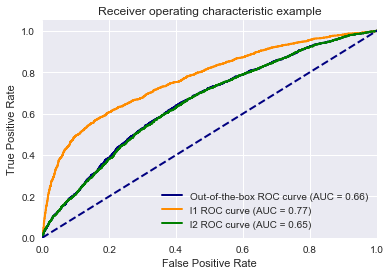

In [24]:
clf_l1 = LogisticRegression(penalty='l1', C=0.078805)
clf_l2 = LogisticRegression(penalty='l2', C=0.078805)

n_classes = len(defaults_df.Y)

y_score = clf.fit(Xtrain, ytrain).decision_function(Xtest)
y_score_l1 = clf_l1.fit(Xtrain, ytrain).decision_function(Xtest)
y_score_l2 = clf_l2.fit(Xtrain, ytrain).decision_function(Xtest)

# Out of box
fpr = dict()
tpr = dict()
roc_auc = dict()
#l1
fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()
#l2
fpr2 = dict()
tpr2 = dict()
roc_auc2 = dict()

# Out-of-the-box
fpr, tpr, _ = roc_curve(ytest, y_score, pos_label=1 )
roc_auc = auc(fpr, tpr)
#l1
fpr1, tpr1, _ = roc_curve(ytest, y_score_l1, pos_label=1 )
roc_auc1 = auc(fpr1, tpr1)
#l2
fpr2, tpr2, _ = roc_curve(ytest, y_score_l2, pos_label=1 )
roc_auc2 = auc(fpr2, tpr2)

# Plot Precision-Recall curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='navy',
         lw=lw, label='Out-of-the-box ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot(fpr1, tpr1, color='darkorange', 
         lw=lw, label='l1 ROC curve (AUC = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='g',
         lw=lw, label='l2 ROC curve (AUC = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

There it is. Well, either we have the perfect algorithm or there is some misclassification going on in the 'optimal' l1 regularized logistic regression curve. To resolve this, we need to turn to precision-recall curves.

## Precision Recall Curves

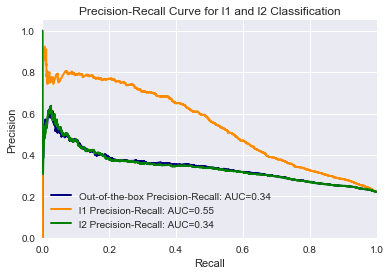

In [25]:
# Compute Precision-Recall and plot curve
precision = dict()
precision_1 = dict()
precision_2 = dict()
recall = dict()
recall_1 = dict()
recall_2 = dict()

average_precision = dict()
average_precision_1 = dict()
average_precision_2 = dict()

precision, recall, _ = precision_recall_curve(ytest, y_score)
precision_1, recall_1, _ = precision_recall_curve(ytest, y_score_l1)
precision_2, recall_2, _ = precision_recall_curve(ytest, y_score_l2)
average_precision = average_precision_score(ytest, y_score)
average_precision_1 = average_precision_score(ytest, y_score_l1)
average_precision_2 = average_precision_score(ytest, y_score_l2)

# Plot Precision-Recall curve
plt.clf()
plt.plot(recall, precision, lw=lw, color='navy',
         label='Out-of-the-box Precision-Recall: AUC={0:0.2f}'.format(average_precision))
plt.plot(recall_1, precision_1, lw=lw, color='darkorange',
         label='l1 Precision-Recall: AUC={0:0.2f}'.format(average_precision_1))
plt.plot(recall_2, precision_2, lw=lw, color='g',
         label='l2 Precision-Recall: AUC={0:0.2f}'.format(average_precision_2))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for l1 and l2 Classification')
plt.legend(loc="lower left")
plt.show()

So here we have a Precision-Recall curve that says that l1-logistic regression is absolutely perfect in predicting when a person will default in the next month, based on the information I provided before. Does that sound right? No, this model must be overfit to the data that we provided. Now it's time to implement some measures to avoid this overfitting behavior and create a classification algorithm that does better than the regular l2-logistic regression model.

In [ ]:
test_array = clf_l1.predict(Xtest)
#a[numpy.where(a > 2)]
np.array_equal(ytest, test_array)

Wow, so this actually predicts all of the values. That doesn't seem right at all, but I really don't know how to check at this point. More research is needed.

## Classification Matrix of l1 and l2 Regularization

[[5841    0]
 [1659    0]]
5573 268 1078 581
             precision    recall  f1-score   support

          0       0.84      0.95      0.89      5841
          1       0.69      0.35      0.46      1659

avg / total       0.80      0.82      0.80      7500

Confusion matrix, without normalization
[[5573  268]
 [1078  581]]


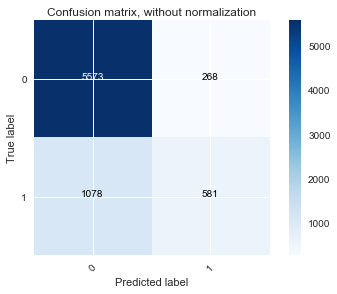

In [26]:
# l1 regularization
print(confusion_matrix(ytest, clf.fit(Xtrain, ytrain).predict(Xtest)))
tn, fp, fn, tp = confusion_matrix(ytest, clf_l1.fit(Xtrain, ytrain).predict(Xtest)).ravel()
print(tn, fp, fn, tp)
target_names = ['0', '1']
print(classification_report(ytest, clf_l1.fit(Xtrain, ytrain).predict(Xtest), target_names=target_names))

# Compute confusion matrix
cnf_matrix = confusion_matrix(ytest, clf_l1.fit(Xtrain, ytrain).predict(Xtest))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')

plt.show()

[[5841    0]
 [1659    0]]
5841 0 1659 0


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.78      1.00      0.88      5841
          1       0.00      0.00      0.00      1659

avg / total       0.61      0.78      0.68      7500

Confusion matrix, without normalization
[[5841    0]
 [1659    0]]


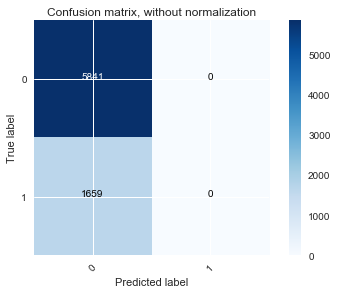

In [27]:
# l2 regularization
print(confusion_matrix(ytest, clf.fit(Xtrain, ytrain).predict(Xtest)))
tn, fp, fn, tp = confusion_matrix(ytest, clf_l2.fit(Xtrain, ytrain).predict(Xtest)).ravel()
print(tn, fp, fn, tp)
target_names = ['0', '1']
print(classification_report(ytest, clf_l2.fit(Xtrain, ytrain).predict(Xtest), target_names=target_names))

# Compute confusion matrix
cnf_matrix = confusion_matrix(ytest, clf_l2.fit(Xtrain, ytrain).predict(Xtest))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')

plt.show()